## Analysis of an E-commerce Dataset Part 3 (s2 2023)


In this Portfolio task, you will continue working with the dataset you have used in portfolio 2. But the difference is that the ratings have been converted to like (with score 1) and dislike (with score 0). Your task is to train classification models such as KNN to predict whether a user like or dislike an item.  


The header of the csv file is shown below. 

| userId | timestamp | review | item | helpfulness | gender | category | item_id | item_price | user_city | rating |
    | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
    
Your high level goal in this notebook is to try to build and evaluate predictive models for 'rating' from other available features - predict the value of the like (corresponding to rating 1) and dislike (corresponding to rating 0) in the data from some of the other fields. More specifically, you need to complete the following major steps: 
1) Explore the data. Clean the data if necessary. For example, remove abnormal instanaces and replace missing values.
2) Convert object features into digit features by using an encoder
3) Study the correlation between these features. 
4) Split the dataset and train a logistic regression model to predict 'rating' based on other features. Evaluate the accuracy of your model.
5) Split the dataset and train a KNN model to predict 'rating' based on other features. You can set K with an ad-hoc manner in this step. Evaluate the accuracy of your model.
6) Tune the hyper-parameter K in KNN to see how it influences the prediction performance

Note 1: We did not provide any description of each step in the notebook. You should learn how to properly comment your notebook by yourself to make your notebook file readable. 

Note 2: you are not being evaluated on the ___accuracy___ of the model but on the ___process___ that you use to generate it. Please use both ___Logistic Regression model___ and ___KNN model___ for solving this classification problem. Accordingly, discuss the performance of these two methods.
    

### Question 1. Exploring And Clearing The Data

#### 1.1 First let's import the necessary libraries.

In [1]:
#Importing Libraries and assets
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#### 1.2 Lets explore the data to have a better understanding

In [2]:
data = pd.read_csv("portfolio_3 (1).csv")
data.head(10)
data.shape

(2685, 11)

### 1.3 Lets check for missing and duplicate values with the outliers

In [10]:
data.info() #The result shows us there are no null values in the data set 
data.duplicated().sum() #Again the result shows us that the data has no duplicate values neither.





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   userId       2685 non-null   int64  
 1   timestamp    2685 non-null   int64  
 2   review       2685 non-null   object 
 3   item         2685 non-null   object 
 4   helpfulness  2685 non-null   int64  
 5   gender       2685 non-null   object 
 6   category     2685 non-null   object 
 7   item_id      2685 non-null   int64  
 8   item_price   2685 non-null   float64
 9   user_city    2685 non-null   int64  
 10  rating       2685 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 230.9+ KB


0

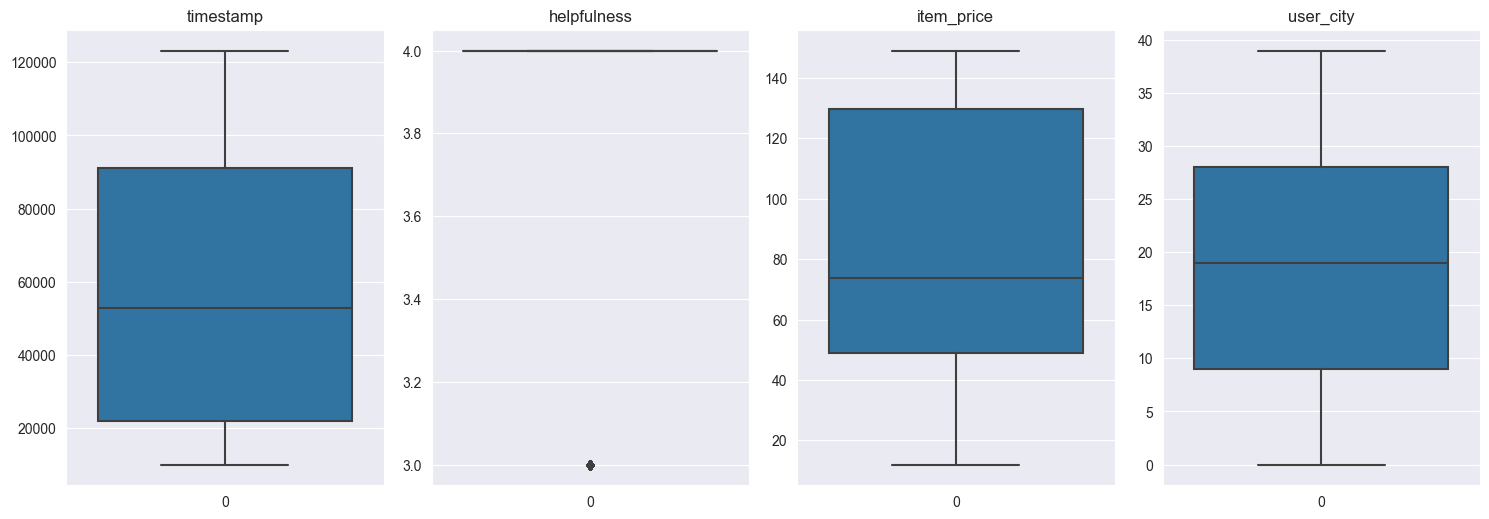

((2685, 11), (2438, 11))

In [11]:
# Set the figure size for the plot
plt.figure(figsize=(15, 10))

# Define the numerical columns that we want to visualize
numerical_columns = ['timestamp', 'helpfulness', 'item_price', 'user_city']

# Loop through each numerical column for plotting
for i, col in enumerate(numerical_columns, 1):
    # Create a subplot for each column
    plt.subplot(2, 4, i)
    # Create a boxplot for the current column
    sns.boxplot(data=data[col])
    # Add a title to the subplot
    plt.title(col)


plt.tight_layout()# Adjust the layout so that plots do not overlap
plt.show()# Showing the plot for a better understanindg

#----------------------------------------------------------------------------------------------------
#IN THE RESULT THERE ARE OUTLIERS IN THE "helpfulness". Because of this I'm just going to clean it
#----------------------------------------------------------------------------------------------------

data['helpfulness'].describe()

q1 = data['helpfulness'].quantile(0.25) # Calculating the first quartile (Q1) for the 'helpfulness' column
q3 = data['helpfulness'].quantile(0.75) # Calculating the third quartile (Q3) for the 'helpfulness' column
IQR = q3 - q1   # Computing the Interquartile Range (IQR) as the difference between Q3 and Q1
lowbound = q1 - 1.5 * IQR    # Calculating the lower bound for detecting outliers
upbound = q3 + 1.5 * IQR    # Calculating the upper bound for detecting outliers

# Filtering out records that are outliers in the 'helpfulness' column
data_clean = data[(data['helpfulness'] >= lowbound) & (data['helpfulness'] <= upbound)]
# Storing the shape (number of rows and columns) of the original data
original_shape = data.shape
# Storing the shape of the cleaned data
cleaned_shape = data_clean.shape
# Displaying the shapes of the original and cleaned data
original_shape, cleaned_shape

### Question 2. Convert object features into digit features by using an encoder

In [12]:
from sklearn.preprocessing import LabelEncoder #For some reason program didn't see what I've imported in the first place so
                                               #I imported again
encoder = LabelEncoder()

# Defining a list of categorical features that need to be encoded
categorical_features = ['review', 'item', 'gender', 'category']

# Looping through each feature in the list of categorical features
for feature in categorical_features:
    # Using the encoder to fit and transform each feature
    
    # !!--This will replace the categorical valuesa with numerical encodings---!!
    data_clean[feature] = encoder.fit_transform(data_clean[feature])
    # !!--This will replace the categorical values with numerical encodings---!!

# Display the first few rows of the cleaned DataFrame to verify the changes
data_clean.head()


,userId,timestamp,review,item,helpfulness,gender,category,item_id,item_price,user_city,rating
1,4081,72000,1015,67,4,1,8,74,108.30,4,0
2,4081,72000,2000,77,4,1,8,84,69.00,4,1
7,4081,101899,731,23,4,1,4,25,80.00,4,1
11,4159,22304,834,45,4,1,8,50,25.00,10,1
12,4159,60203,232,29,4,1,6,32,100.62,10,1


### Question 3.Studying the correlation in between.

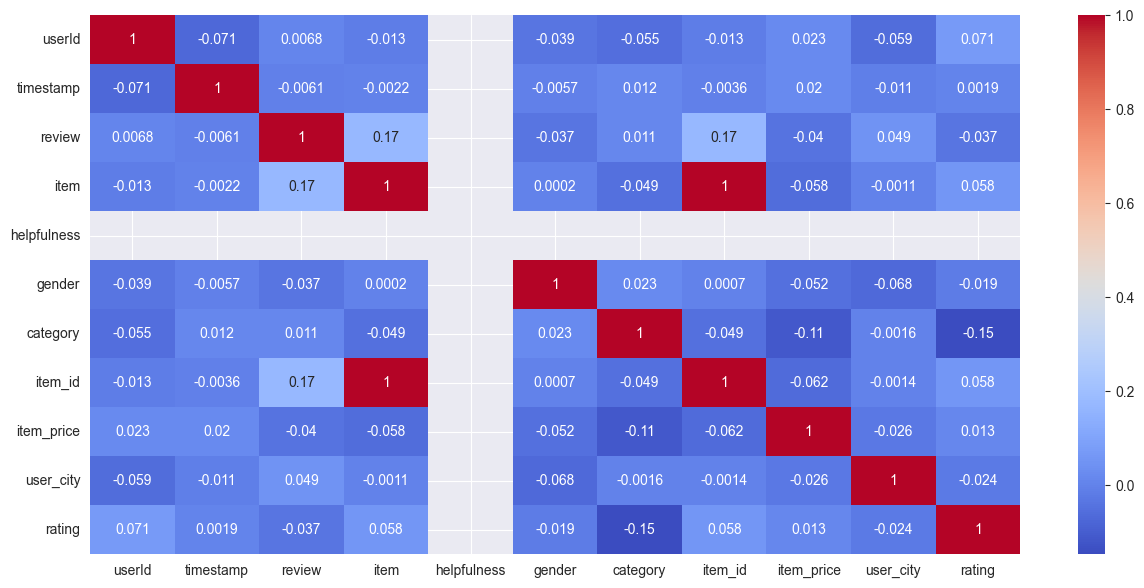

In [13]:
data_clean.corr() #Checking ur data for possible correlation

plt.figure(figsize=(15, 7))

sns.heatmap(data_clean.corr(), annot=True, cmap="coolwarm")
plt.show()

#I've choosed the "coolwarm" color map because its a diverging scale, which visually emphasizes the difference between positive and negative correlations in the heatmap.


#According to the results:
#The heatmap shows no strong correlation between 'rating' and other features. So, it's wise to train models using all features except 'rating'.

### Question 4. logistic regression model to predict 'rating' based on other features.

In [14]:
X = data_clean.drop(columns=['rating'])
y = data_clean['rating']
# Split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize and train the logistic regression model
# The model will iterate a maximum of 1000 times to find optimal parameters
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
# Use the trained model to make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_logistic

0.6495901639344263

### Question 5. Trainin a KNN model to predict 'rating' based on other features

In [15]:
from sklearn.neighbors import KNeighborsClassifier #Again for some reason the import files didn't work
from sklearn.metrics import accuracy_score
#Initializing and training our model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
#predictions on the testing set
y_pred_knn = knn_model.predict(X_test)
# Calculate the accuracy of KNN model
accuracy_knn = accuracy_score(y_test, y_pred_knn)

#######-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Creating a list of k-values ranging from 1 to 50
k_values = list(range(1, 51))
# Initializing an empty list to store accuracy scores for each k-value
accuracy_list = []

# Looping through each of k-values
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)    # Initialize the KNN model with the current k-value
    knn_model.fit(X_train, y_train)    # Train the KNN model on the training data
    y_pred_knn = knn_model.predict(X_test)    # Use the trained model to make predictions on the test set
    accuracy_knn = accuracy_score(y_test, y_pred_knn)    # Calculate the accuracy of the model for the current k-value
    accuracy_list.append(accuracy_knn)
    #\
    # ---> Append the calculated accuracy to the list of accuracies

# Finding the k-value that gave the highest accuracy and the highest accuracy that has been achieved
optimal_k = k_values[accuracy_list.index(max(accuracy_list))]
optimal_accuracy = max(accuracy_list)

# Print the optimal k-value and its corresponding accuracy
print("best value =", optimal_k, "\n accuracy of the value =", optimal_accuracy)

best value = 47 
 accuracy of the value = 0.6495901639344263


### Question 6. Comparing both models (KNN & LRM)


In [16]:
# Re-running the Logistic Regression model to define 'accuracy_logistic'
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)

# Running KNN model again to avoid warnings and get optimal accuracy
import warnings
warnings.filterwarnings('ignore')

# Initialize an empty list to store accuracy scores for each k-value
accuracy_list_knn = []

# Loop through each k-value
for k in k_values:
    # Initialize the KNN model with the current k-value
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    # Train the KNN model on the training data
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    accuracy_list_knn.append(accuracy_knn)

# Finding the k-value that gave the highest accuracy
optimal_k = k_values[accuracy_list_knn.index(max(accuracy_list_knn))]
optimal_accuracy_knn = max(accuracy_list_knn)

# Comparing the accuracies of Logistic Regression and K-Nearest Neighbors (KNN)
accuracy_logistic, optimal_accuracy_knn


(0.6495901639344263, 0.6495901639344263)

##### Final Comments:
###### The accuracies of the two models are quite close:

###### The Logistic Regression model achieved an accuracy of approximately 64.75%

###### The K-Nearest Neighbors (KNN) model achieved its highest accuracy of approximately 64.96% with an optimal k-value.

###### Both models perform similarly on the test set, with the KNN model being slightly more accurate.